In [1]:
#@title foo
#!pip install transformers==4.1.1 plotnine

In [2]:
import re
import itertools

import numpy as np
import pandas as pd

from IPython.display import HTML
import seaborn
import plotnine
from plotnine import *

from ahviz import create_indices, create_dataframe, filter_mask
import torch
from transformers import AutoModel, AutoTokenizer

plotnine.options.figure_size = (12, 12)

In [3]:
plotnine.options.figure_size = (20, 20)

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [5]:
#device = torch.device("cpu")

In [6]:
transformer = "bert-base-cased"
#transformer = "gpt2"
#transformer = "gpt2-medium"
#transformer = "gpt2-large"
#transformer = "twmkn9/bert-base-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(transformer)

# gpt2 doesn't do padding, so invent a padding token
# this one was suggested by the error you get when trying
# to do masking below, but it shouldn't matter as the actual
# tokens get ignored by the attention mask anyway
if transformer in ['gpt2', 'gpt2-medium', 'gpt2-large']:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModel.from_pretrained(transformer, output_attentions=True, output_hidden_states=True)
model.to(device)
model.eval()
model.zero_grad()


In [7]:
# read the prepared data.
# based on the penn treebank sample in nltk; prepared with the convert_corpus.py script
sentences = pd.read_csv("lines.csv")
sentences['length'] = sentences.line.str.split().apply(len)
display(sentences[sentences['length'] <100].length.describe())

count    3913.000000
mean       20.652952
std         9.943947
min         1.000000
25%        13.000000
50%        20.000000
75%        27.000000
max        80.000000
Name: length, dtype: float64

In [8]:
concatenated = " ".join(sentences['line'].tolist())

In [9]:
window_size = 100
step = 50
future = 20

In [10]:
tokens = torch.tensor(tokenizer(concatenated)['input_ids'])
tokens.shape

Token indices sequence length is longer than the specified maximum sequence length for this model (111588 > 512). Running this sequence through the model will result in indexing errors


torch.Size([111588])

In [11]:
pad_len = window_size - len(tokens) % window_size

In [12]:
pad_len

12

In [13]:
padded = torch.cat((tokens, tokens.new_full((pad_len,), tokenizer.pad_token_id)))
padded.shape

torch.Size([111600])

In [14]:
padded.unfold(0, window_size, step)[:3]


tensor([[  101,  4855, 25354,  6378,   117,  5391,  1201,  1385,   117,  1209,
          2866,  1103,  2313,  1112,   170,  3839, 16056, 12734,  2109,  1900,
         14152,   119,  1853,   119,  1828,   119, 25354,  6378,  1110,  3931,
          1104,  2896,  2217, 15339,   151,   119,   159,   119,   117,  1103,
          2954,  5550,  1372,   119, 19922,   138,  8376,  2246,   117,  3731,
          1201,  1385,  1105,  1393,  3931,  1104, 23582,  3487, 11628,   153,
         12674,   117,  1108,  1417,   170,  3839, 16056, 12734,  2109,  1900,
          1104,  1142,  1418,  3924, 27482,   119,   138,  1532,  1104,  1112,
         12866, 11990,  1517,  1215,  1106,  1294,  5327,  9983, 19690,  1144,
          2416,   170,  1344,  6556,  1104,  4182,  6209,  1621,   170,  1372],
        [ 1201,  1385,  1105,  1393,  3931,  1104, 23582,  3487, 11628,   153,
         12674,   117,  1108,  1417,   170,  3839, 16056, 12734,  2109,  1900,
          1104,  1142,  1418,  3924, 27482,   119, 

In [15]:
mask = torch.cat((torch.zeros(window_size - (step + future)), torch.ones(step), torch.zeros(future))).expand((100,-1))[0]

print(mask)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [16]:
def get_batches(input_tensor:torch.Tensor, size: int, step: int, batch_size :int = 2):
    input_ids = input_tensor.unfold(0, size, step)
    attention_mask = torch.cat((torch.zeros(window_size - step), torch.ones(step))).expand((input_ids.size(0),-1))
    tensor_dataset = torch.utils.data.TensorDataset(input_ids, attention_mask)
    tensor_dataloader = torch.utils.data.DataLoader(tensor_dataset, batch_size=batch_size)
    
    return tensor_dataloader

In [17]:
dl = get_batches(padded, window_size, step, batch_size=3)

In [18]:
data = None
for batch, t in enumerate(dl):
    input_dict = {k: v.to(device) for k, v in zip(["input_ids", "attention_mask"], t)}
    
    output = model(**input_dict)

    att = np.array([a.cpu().detach().numpy() for a in output['attentions']])
    #print(att.shape)

    # sort all the attention softmax vectors in descending order
    sorted = np.take_along_axis(att, (-att).argsort(), axis=-1)

    # add them up cumulatively
    cum = sorted.cumsum(axis=-1)

    # determine which ones are below 0.9
    limit = np.where(cum < 0.9, True, False)

    # count the ones below 0.9; k is that sum + 1
    k = limit.sum(axis=-1) + 1

    # swap the 'head' and 'sentence' axes so we can more easily apply the attention mask
    ks = np.swapaxes(k, 1, 2)

#    # use the attention mask to flag the padding tokens
#    att_mask = input_dict['attention_mask'].cpu().detach()
#    mt = np.ma.MaskedArray(ks, mask = (att_mask == False).expand(ks.shape))
#
#    # flatten out the sentences so we're left with just a list of tokens
#    mr = mt.reshape(ks.shape[:2] + tuple([np.prod(ks.shape[2:])]))
#
#    # find the indices of the token list we're interested in
#    unmasked = np.flatnonzero(att_mask)
#
#    # get the dimensions of the data we want
#    # layer × head × #tokens
#    l, h, v = mr[:, :, unmasked].shape
#
#    # create a layer/head multiindex
#    ix = pd.MultiIndex.from_arrays(
#        [
#            np.repeat(np.arange(l) + 1,h),
#            np.tile(np.arange(h) + 1, l)
#        ], 
#        names=['layer', 'head'])
#
#    # finally filter out the padding tokens, put the data in a dataframe,
#    # and transform it so we get one layer/head/token/k per row
#    batch_data = (
#            pd.DataFrame(mr[:,:,unmasked].reshape((l*h,len(unmasked))), index=ix)
#                .reset_index()
#                .melt(id_vars=['layer', 'head'])
#        )
#    batch_data['batch'] = batch
    if data is None:
        data = ks
    else:
        data = np.concatenate([data, ks], axis=2)


In [19]:
print(data.shape)
display(data)


(12, 12, 2231, 100)


array([[[[37, 27, 36, ..., 31, 40, 39],
         [33, 36, 37, ..., 38, 37, 35],
         [35, 37, 34, ..., 38, 37, 35],
         ...,
         [35, 29, 37, ..., 30, 34, 38],
         [35, 37, 38, ..., 40, 37, 37],
         [28, 41, 37, ..., 37, 37, 37]],

        [[42, 29, 33, ..., 14, 13, 13],
         [40, 36, 36, ..., 12, 12, 14],
         [41, 31, 31, ...,  9,  7, 11],
         ...,
         [41, 32, 32, ..., 13, 11,  8],
         [41, 35, 33, ..., 10, 12, 11],
         [39, 36, 31, ...,  8,  8,  7]],

        [[41, 38, 38, ..., 39, 40, 36],
         [38, 38, 42, ..., 37, 41, 40],
         [42, 36, 29, ..., 39, 37, 38],
         ...,
         [41, 36, 42, ..., 40, 38, 40],
         [39, 42, 36, ..., 42, 37, 38],
         [40, 38, 35, ..., 36, 36, 37]],

        ...,

        [[39, 35, 36, ..., 37, 41, 35],
         [39, 40, 39, ..., 33, 38, 36],
         [41, 39, 40, ..., 32, 36, 37],
         ...,
         [40, 36, 34, ..., 39, 38, 41],
         [39, 37, 34, ..., 39, 35, 37],
    

In [20]:
ix = create_indices(data, names=['layer', 'head', 'sample', 'from_token'])

In [21]:
df = create_dataframe(data, ix)

In [22]:
display(df)

,from_token,sample,head,layer,attention_fraction
0,1,1,1,1,37
1,2,1,1,1,27
2,3,1,1,1,36
3,4,1,1,1,38
4,5,1,1,1,40
...,...,...,...,...,...
32126395,96,2231,12,12,13
32126396,97,2231,12,12,13
32126397,98,2231,12,12,13
32126398,99,2231,12,12,12


In [23]:
df.describe()

,from_token,sample,head,layer,attention_fraction
count,3.212640e+07,3.212640e+07,3.212640e+07,3.212640e+07,3.212640e+07
mean,5.050000e+01,1.116000e+03,6.500000e+00,6.500000e+00,1.426746e+01
std,2.886607e+01,6.440342e+02,3.452053e+00,3.452053e+00,1.065721e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,2.575000e+01,5.580000e+02,3.750000e+00,3.750000e+00,6.000000e+00
50%,5.050000e+01,1.116000e+03,6.500000e+00,6.500000e+00,1.100000e+01
75%,7.525000e+01,1.674000e+03,9.250000e+00,9.250000e+00,2.200000e+01
max,1.000000e+02,2.231000e+03,1.200000e+01,1.200000e+01,4.500000e+01


In [24]:
filtered = df[(df['from_token']>(window_size-(step+future))) & (df['from_token']<=(window_size-future)) ].rename(columns={'attention_fraction': "value"})
display(filtered)

,from_token,sample,head,layer,value
30,31,1,1,1,39
31,32,1,1,1,30
32,33,1,1,1,36
33,34,1,1,1,36
34,35,1,1,1,39
...,...,...,...,...,...
32126375,76,2231,12,12,7
32126376,77,2231,12,12,6
32126377,78,2231,12,12,3
32126378,79,2231,12,12,3


In [25]:
filtered.describe()

,from_token,sample,head,layer,value
count,1.606320e+07,1.606320e+07,1.606320e+07,1.606320e+07,1.606320e+07
mean,5.550000e+01,1.116000e+03,6.500000e+00,6.500000e+00,1.383991e+01
std,1.443087e+01,6.440342e+02,3.452053e+00,3.452053e+00,1.055339e+01
min,3.100000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,4.300000e+01,5.580000e+02,3.750000e+00,3.750000e+00,5.000000e+00
50%,5.550000e+01,1.116000e+03,6.500000e+00,6.500000e+00,1.000000e+01
75%,6.800000e+01,1.674000e+03,9.250000e+00,9.250000e+00,2.100000e+01
max,8.000000e+01,2.231000e+03,1.200000e+01,1.200000e+01,4.500000e+01


In [26]:
avg_k = filtered.groupby(['layer', 'head']).agg(avg_k = pd.NamedAgg('value', np.median)).reset_index()

To replicate the plot in the hopfield network paper better, add a `sorted_head` column just so we can plot the attention heads per layer sorted from small to large k

In [27]:
l, h = 12, 12

In [28]:
sorted_avg_k = avg_k.sort_values(["layer", "avg_k"]) 
sorted_avg_k['sorted_head'] = np.tile(np.arange(h) + 1, l)


In [29]:
# merge this sorted_head column into the original data too
data_sh = filtered.merge(sorted_avg_k[['layer', 'head', 'sorted_head']], on=["layer", "head"])

In [30]:
print(data_sh)

          from_token  sample  head  layer  value  sorted_head
0                 31       1     1      1     39            9
1                 32       1     1      1     30            9
2                 33       1     1      1     36            9
3                 34       1     1      1     36            9
4                 35       1     1      1     39            9
...              ...     ...   ...    ...    ...          ...
16063195          76    2231    12     12      7            1
16063196          77    2231    12     12      6            1
16063197          78    2231    12     12      3            1
16063198          79    2231    12     12      3            1
16063199          80    2231    12     12      4            1

[16063200 rows x 6 columns]


In [31]:
data_sh.describe()

,from_token,sample,head,layer,value,sorted_head
count,1.606320e+07,1.606320e+07,1.606320e+07,1.606320e+07,1.606320e+07,1.606320e+07
mean,5.550000e+01,1.116000e+03,6.500000e+00,6.500000e+00,1.383991e+01,6.500000e+00
std,1.443087e+01,6.440342e+02,3.452053e+00,3.452053e+00,1.055339e+01,3.452053e+00
min,3.100000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,4.300000e+01,5.580000e+02,3.750000e+00,3.750000e+00,5.000000e+00,3.750000e+00
50%,5.550000e+01,1.116000e+03,6.500000e+00,6.500000e+00,1.000000e+01,6.500000e+00
75%,6.800000e+01,1.674000e+03,9.250000e+00,9.250000e+00,2.100000e+01,9.250000e+00
max,8.000000e+01,2.231000e+03,1.200000e+01,1.200000e+01,4.500000e+01,1.200000e+01


In [32]:
# position of the avg_k value in the plot
ypos = data_sh['value'].max() * .5

## Plots

## first in the natural order of the layers/heads

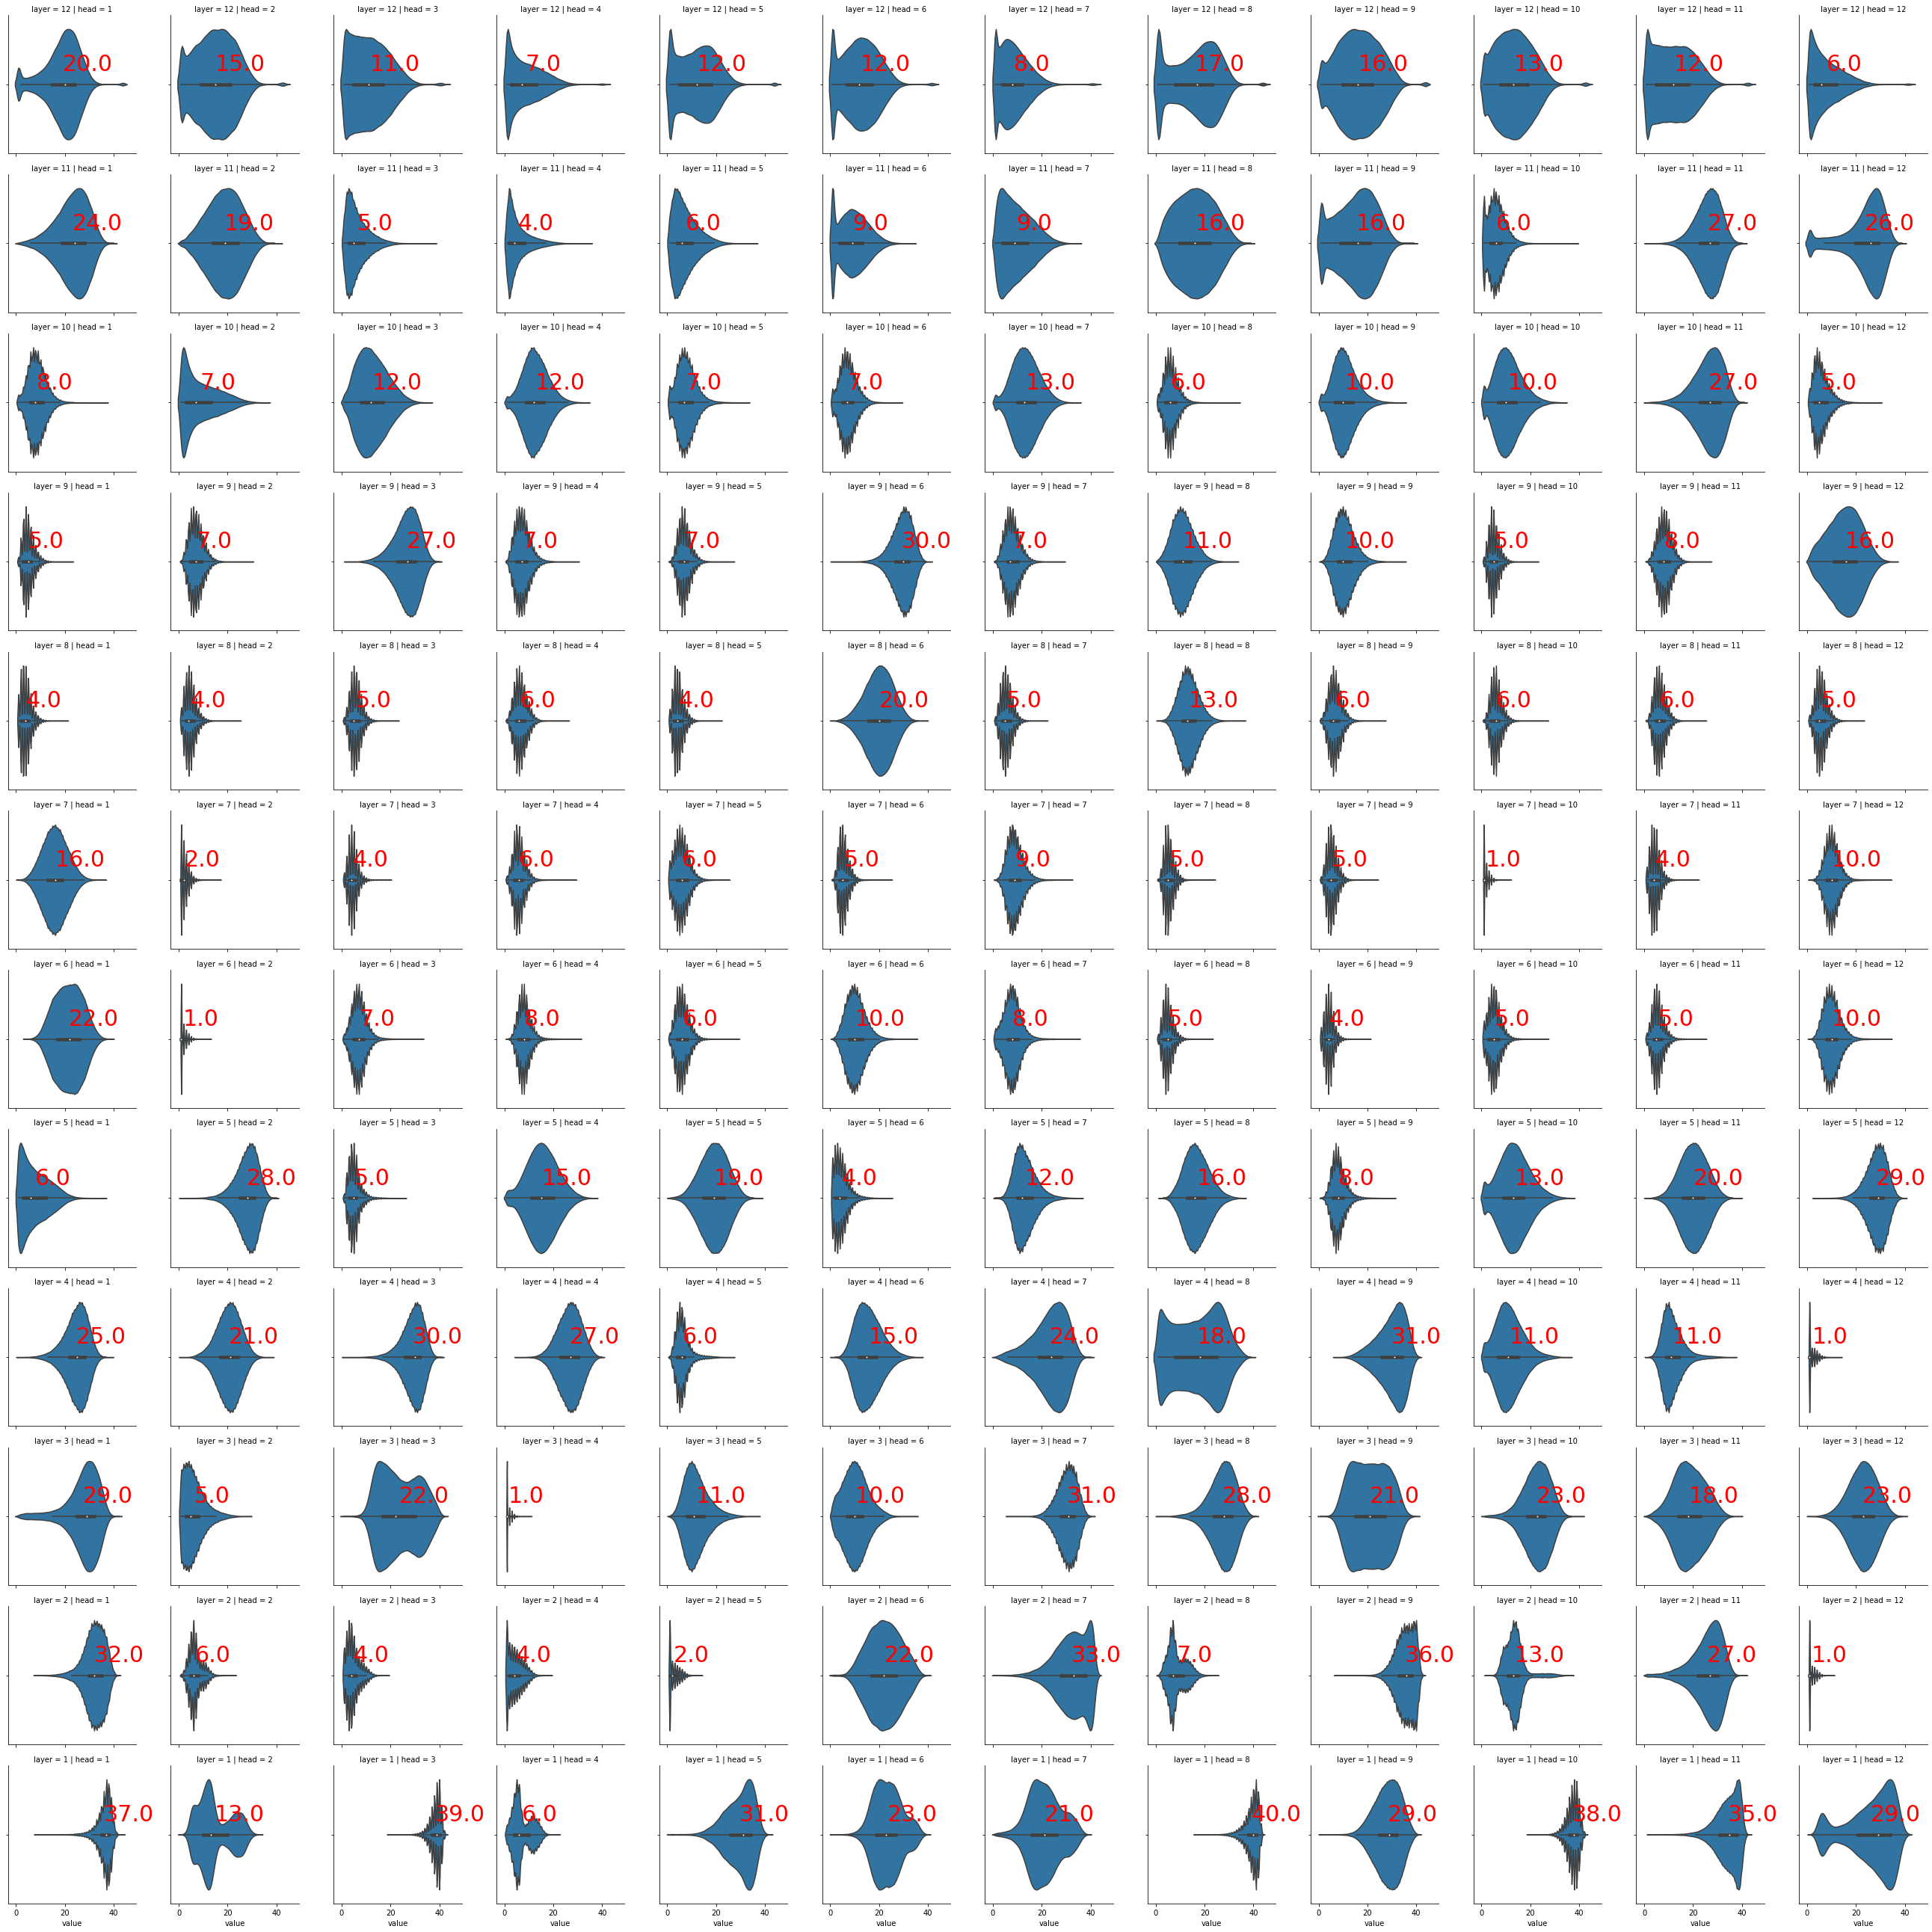

In [33]:
def make_violin(x, **kwargs):
    v = seaborn.violinplot(x=x, **kwargs)
    data = kwargs['data']
    median_k = np.median(data[x])
    mean = np.mean(data[x])
    v.text(mean, -0.1, str(median_k), fontdict=dict(color="red", fontsize=30))
    return v
g = seaborn.FacetGrid(data_sh, col="head",  row="layer", col_order=(np.arange(h) + 1), row_order=np.flip(np.arange(l) + 1))
g.map_dataframe(make_violin, "value")

### And the heads per layer sorted by the median k, like in the hopfield networks paper

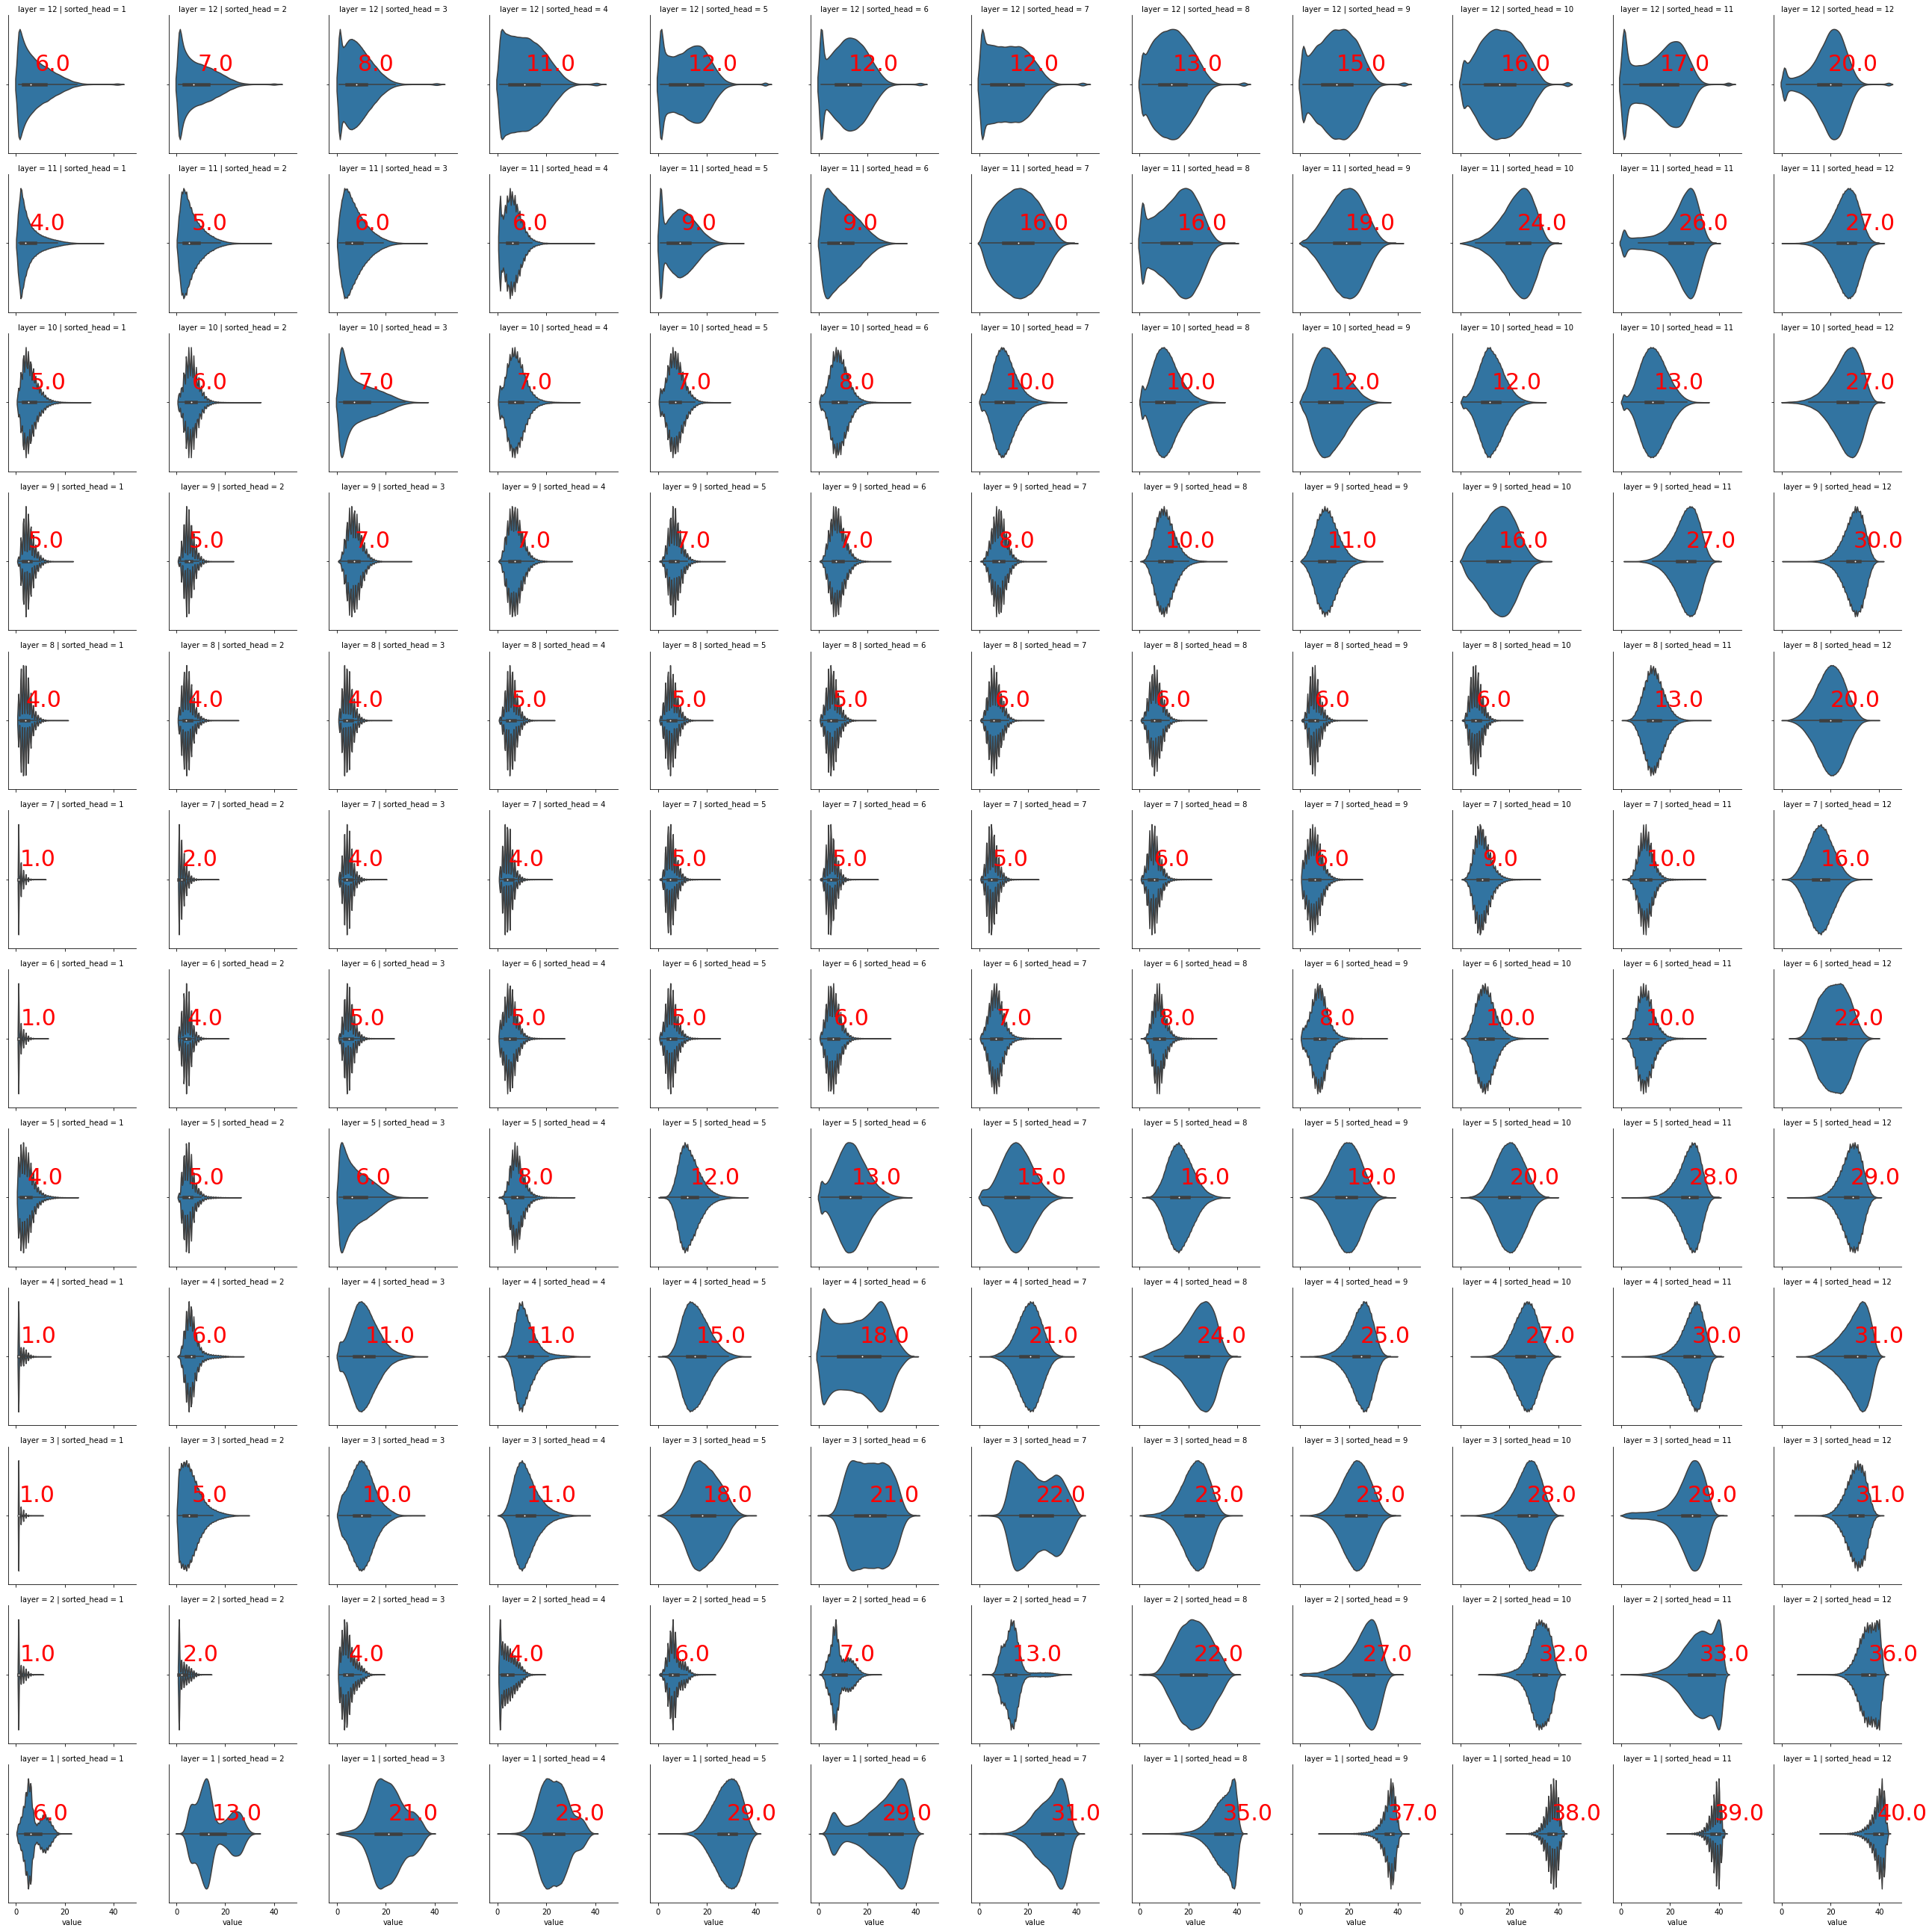

In [35]:
g = seaborn.FacetGrid(data_sh, col="sorted_head",  row="layer", col_order=(np.arange(h) + 1), row_order=np.flip(np.arange(l) + 1))
g.map_dataframe(make_violin, "value")